In [123]:
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
import tqdm

from torch_geometric.datasets.karate import KarateClub
from torch_geometric import utils
from torch_geometric.loader import LinkNeighborLoader

In [8]:
karate = KarateClub()
karate.data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [166]:
def plot_random_link_split(disjoint_train_ratio):
    transform = T.RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        is_undirected=True,
        disjoint_train_ratio=disjoint_train_ratio,
        neg_sampling_ratio=1.0,
        add_negative_train_samples=False
    )

    train_data, val_data, test_data = transform(karate.data)
    
    fig, axis = plt.subplots(nrows=1, ncols=4, figsize=(15, 5), )
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
    
    G = utils.to_networkx(karate.data, to_undirected=True)
    pos = nx.layout.kamada_kawai_layout(G)
    nx.draw(G, pos=pos, ax=axis[0])
    axis[0].set_title(('Graph'), fontdict={'fontsize': 10})
    
    G_train = utils.to_networkx(train_data, to_undirected=True)
    nx.draw(G_train, pos=pos, ax=axis[1])   
    nx.draw_networkx_edges(G_train, pos=pos, edge_color='red', edgelist=set(G.edges) - set(G_train.edges), ax=axis[1])
    axis[1].set_title(('Train'), fontdict={'fontsize': 10})
    
    G_test = utils.to_networkx(test_data, to_undirected=True)
    nx.draw(G_test, pos=pos, ax=axis[2])      
    nx.draw_networkx_edges(G_test, pos=pos, edge_color='red', edgelist=set(G.edges) - set(G_test.edges), ax=axis[2])
    axis[2].set_title(('Test'), fontdict={'fontsize': 10})
    
    G_val = utils.to_networkx(val_data, to_undirected=True)
    nx.draw(G_val, pos=pos, ax=axis[3])      
    nx.draw_networkx_edges(G_val, pos=pos, edge_color='red', edgelist=set(G.edges) - set(G_val.edges), ax=axis[3])    
    axis[3].set_title(('Valid'), fontdict={'fontsize': 10})

# Random Link Split

Performs an edge-level random split into training, validation and test sets of a **Data** or a **HeteroData** object.  
The split is performed such that the training split does not include edges in validation and test splits; and the validation split does not include edges in the test split.

If set to a value greater than 0.0, training edges will not be shared for message passing and supervision. Instead, disjoint_train_ratio edges are used as ground-truth labels for supervision during training. (default: 0.0).

## Disjoint Train ratio: 0.5

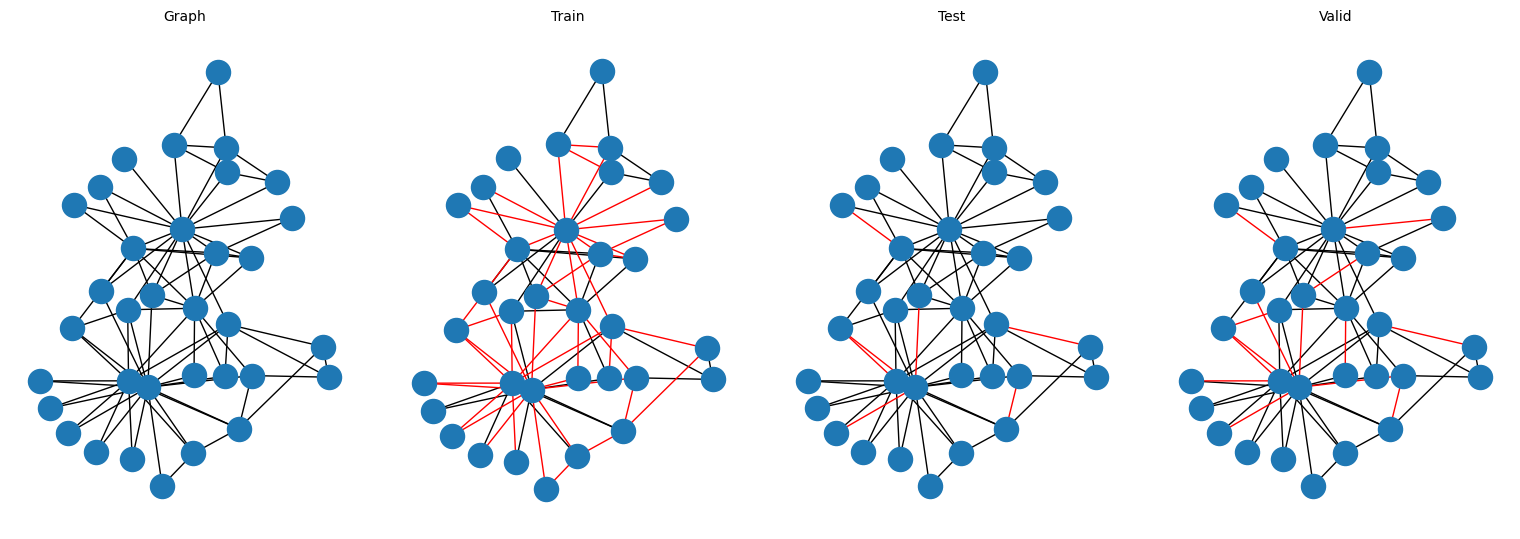

In [167]:
plot_random_link_split(0.5)

## Disjoint Train ratio: 0.1

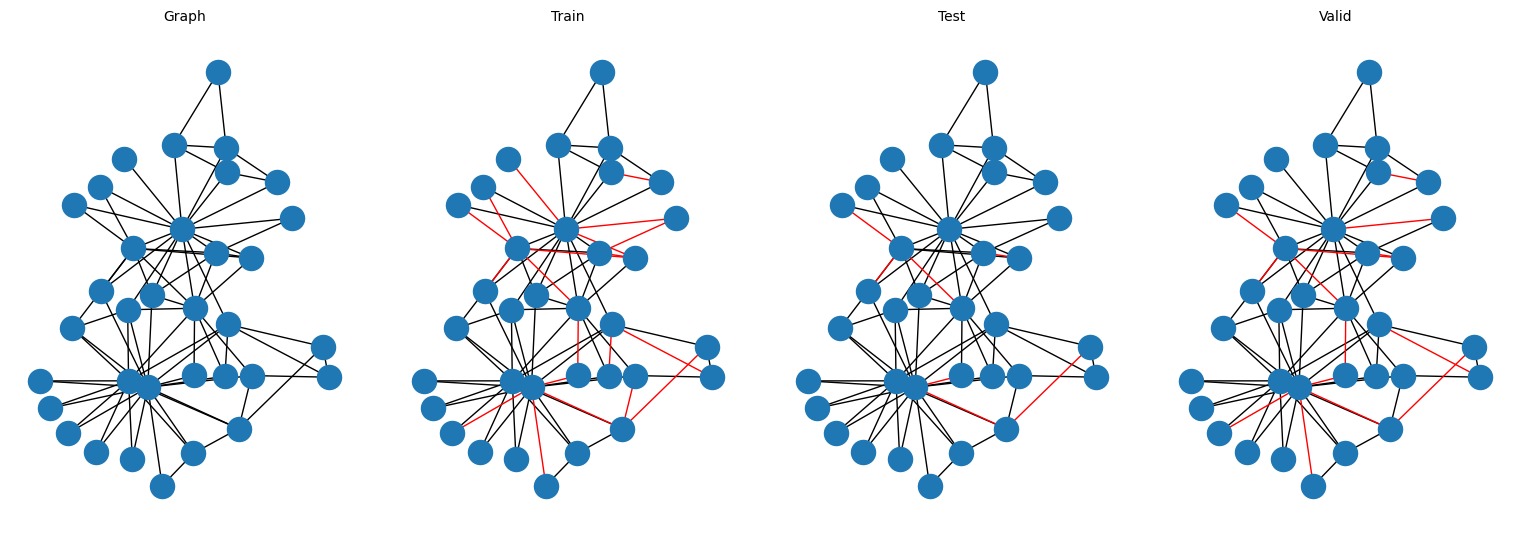

In [168]:
plot_random_link_split(0.1)

## Disjoint Train Ratio: 0

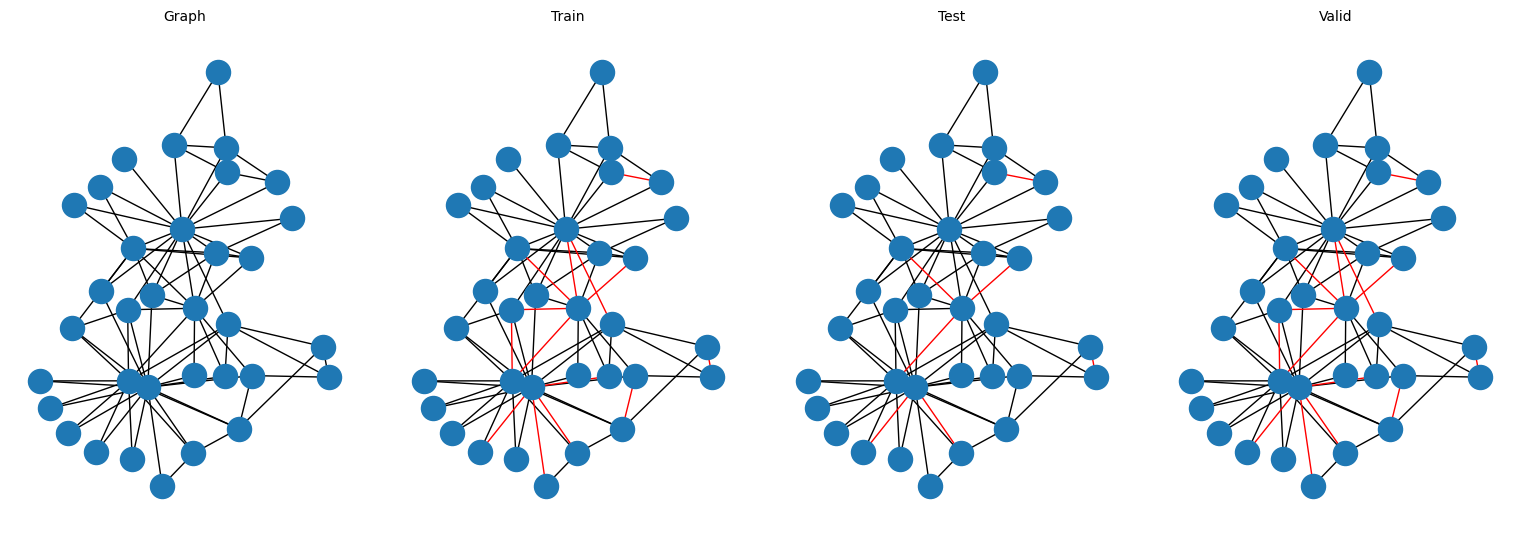

In [169]:
plot_random_link_split(0.0)

# LinkNeighborLoader

A link-based data loader derived as an extension of the node-based torch_geometric.loader.NeighborLoader. This loader allows for mini-batch training of GNNs on large-scale graphs where full-batch training is not feasible.

In [172]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    disjoint_train_ratio=0.0,
    neg_sampling_ratio=1.0,
    add_negative_train_samples=False
)

train_data, val_data, test_data = transform(karate.data)

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 20],
    neg_sampling_ratio=1.0,
    batch_size=10,
    shuffle=True,
    directed=True,
    is_sorted=False
)

green - existent edges  
red   - nonexistent edges

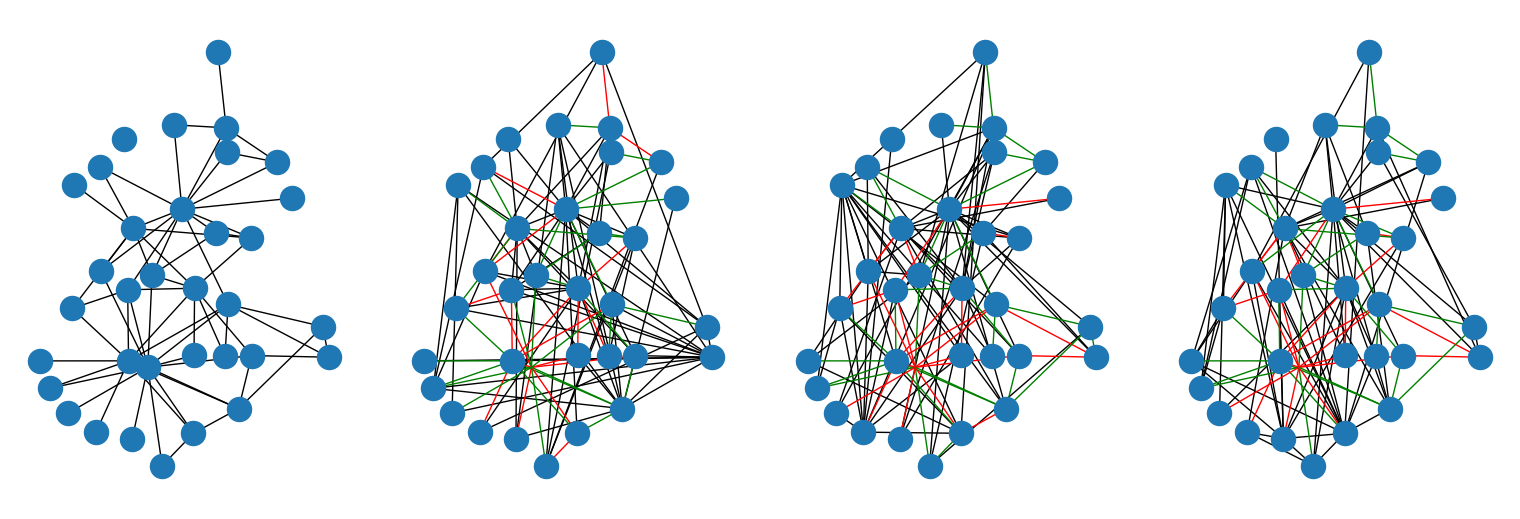

In [182]:
fig, axis = plt.subplots(nrows=1, ncols=4, figsize=(15, 5), )
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)

G_train = utils.to_networkx(train_data, to_undirected=True)
nx.draw(G_train, pos=pos, ax=axis[0]) 

colors = {0: 'red', 1: 'green'}

for i, sampled_data in enumerate(train_loader):

    G_batch = utils.to_networkx(sampled_data, to_undirected=True)
    nx.draw(G_batch, pos=pos, ax=axis[i+1])   
    nx.draw_networkx_edges(G_batch, pos=pos, edge_color=list(map(lambda x: colors[x], sampled_data.edge_label.numpy())), edgelist=set(G_train.edges) - set(G_batch.edges), ax=axis[i+1])
    
    if i == 2:
        break